In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [175]:
target = pd.read_csv("../data/target_train.csv")
sample = pd.read_csv("../data/sample_submission.csv")

plavki_train = pd.read_csv("../data/plavki_train.csv")
plavki_test = pd.read_csv("../data/plavki_test.csv")

gas_train = pd.read_csv("../data/gas_train.csv")
gas_test = pd.read_csv("../data/gas_test.csv")

chugun_train = pd.read_csv("../data/chugun_train.csv")
chugun_test = pd.read_csv("../data/chugun_test.csv")

lom_train = pd.read_csv("../data/lom_train.csv")
lom_test = pd.read_csv("../data/lom_test.csv")

produv_train = pd.read_csv("../data/produv_train.csv")
produv_test = pd.read_csv("../data/produv_test.csv")

chronom_train = pd.read_csv("../data/chronom_train.csv")
chronom_test = pd.read_csv("../data/chronom_test.csv")

sip_train = pd.read_csv("../data/sip_train.csv")
sip_test = pd.read_csv("../data/sip_test.csv")

from pipeline import merge_data

params = {
    "chugun": {},
    "plavki": {"bow_count": 10},
    "vector_size": 10
}

train, test, y, num_features, cat_features = merge_data(
    sample, target, plavki_train, plavki_test, gas_train, gas_test, chugun_train, chugun_test, 
    lom_train, lom_test, produv_train, produv_test, chronom_train, chronom_test, 
    sip_train, sip_test, params
)

  0%|          | 0/2063 [00:00<?, ?it/s]

  0%|          | 0/780 [00:00<?, ?it/s]

In [86]:
from sklearn.model_selection import KFold, TimeSeriesSplit
from tqdm.auto import tqdm, trange

def metric(c_true, tst_true, c_pred, tst_pred, pwc=None, pwt=None):
    
    if pwc is not None:
        c_pred = pwc.inverse_transform(c_pred.reshape(-1, 1)).reshape(-1)
    if pwt is not None:
        tst_pred = pwt.inverse_transform(tst_pred.reshape(-1, 1)).reshape(-1)
    
    delta_c = np.abs(c_true - c_pred)
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(tst_true - tst_pred)
    hit_rate_t = np.int64(delta_t < 20)

    N = c_pred.shape[0]    
    return np.sum(hit_rate_c) / N, np.sum(hit_rate_t) / N, np.sum(hit_rate_c + hit_rate_t) / 2 / N

def pipeline(model_c, model_tst, train_c, test_c, train_tst, test_tst, y, sample, n_splits=10, pwc=None, pwt=None):
    kf = KFold(n_splits=n_splits, shuffle=True)

    sample["C"] = 0
    sample["TST"] = 0
    
    res_c, res_t, res = [], [], []
    for train_idx, test_idx in tqdm(kf.split(train_c), total=n_splits):
        cur_train_c = train_c[train_idx]
        cur_eval_c = train_c[test_idx]        

        cur_train_tst = train_tst[train_idx]
        cur_eval_tst = train_tst[test_idx]

        cur_train_y = y.iloc[train_idx]
        cur_eval_y = y.iloc[test_idx]
        
        if pwc is not None:
            model_c.fit(cur_train_c, pwc.transform(cur_train_y["C"].values.reshape(-1, 1)).reshape(-1))
        else:
            model_c.fit(cur_train_c, cur_train_y["C"])
            
        if pwt is not None:
            model_tst.fit(cur_train_tst, pwt.transform(cur_train_y["TST"].values.reshape(-1, 1)).reshape(-1))
        else:
            model_tst.fit(cur_train_tst, cur_train_y["TST"])
        
        eval_pred_c = model_c.predict(cur_eval_c)
        eval_pred_tst = model_tst.predict(cur_eval_tst)
    
        sample["C"] += model_c.predict(test_c) / n_splits
        sample["TST"] += model_tst.predict(test_tst) / n_splits
        
        hit_rate_c, hit_rate_t, hit_rate = metric(cur_eval_y["C"], cur_eval_y["TST"], eval_pred_c, eval_pred_tst, pwc, pwt)
        res_c.append(hit_rate_c)
        res_t.append(hit_rate_t)
        res.append(hit_rate)
    
    res_c = np.array(res_c)
    res_t = np.array(res_t)
    res = np.array(res)
    print(f"Carbon score: {res_c.mean()} ± {res_c.std()}")
    print(f"Temperature score: {res_t.mean()} ± {res_t.std()}")    
    print(f"Overall score: {res.mean()} ± {res.std()}") 
    
    if pwt is not None:
        sample["TST"] = pwt.inverse_transform(sample["TST"].values.reshape(-1, 1)).reshape(-1)
    if pwc is not None:
        sample["C"] = pwc.inverse_transform(sample["C"].values.reshape(-1, 1)).reshape(-1)
    
    sample["C"] = sample["C"].clip(0, 1)
    
    return sample

In [176]:
from pipeline import transform_for_linear

train_scaled, test_scaled = transform_for_linear(train, num_features, cat_features, test)

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR

from xgboost import XGBRegressor

In [16]:
train_exp = train.drop(columns=['truncated_NMZ'])
test_exp = test.drop(columns=['truncated_NMZ'])

In [20]:
model_c = XGBRegressor(n_estimators=20, max_depth=7)
model_tst = XGBRegressor(n_estimators=20, max_depth=7)

res = pipeline(model_c, model_tst, train_exp.values, test_exp.values, train_exp.values, test_exp.values, y, sample, n_splits=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Carbon score: 0.642891150112024 ± 0.03841876109410508
Temperature score: 0.6389749813293502 ± 0.06252279801789368
Overall score: 0.6409330657206871 ± 0.03512989631263768


In [21]:
sorted(zip(model_c.feature_importances_, train.columns), reverse=True)[:20]

[(0.30263925, 'unique_count'),
 (0.13923663, 'bow_/Э '),
 (0.12412604, 'gas_std_volume_AR'),
 (0.04664408, 'gas_sum_volume_CO2'),
 (0.045238547, 'bow_т3п'),
 (0.024579667, 'MN'),
 (0.019775849, 'max_duration_межпл.прост._1'),
 (0.017551946, 'gas_mean_CO2'),
 (0.017241437, 'RAS_mean'),
 (0.0119070895, 'ves_loma'),
 (0.010698845, 'gas_std_AR'),
 (0.009757485, 'total_duration_межпл.прост._1'),
 (0.0097543895, 'gas_std_volume_N2'),
 (0.009282209, 'total_operations_межпл.прост._1'),
 (0.009172838, 'O2_межпл.прост._1'),
 (0.008292838, 'cr_portion'),
 (0.008147722, 'O2_опер_0'),
 (0.008127391, 'gas_std_V'),
 (0.00660705, 'gas_mean_H2'),
 (0.0065626656, 'gas_sum_volume_O2')]

In [52]:
model_c = RandomForestRegressor(n_estimators=300, max_depth=3, max_features="log2", n_jobs=-1)
model_tst = RandomForestRegressor(n_estimators=300, max_depth=3, max_features="log2", n_jobs=-1)

res = pipeline(model_c, model_tst, train[top_features].values, test[top_features].values, train[top_features].values, test[top_features].values, y, sample, n_splits=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Carbon score: 0.4080517176997759 ± 0.03569376418334986
Temperature score: 0.5133121732636295 ± 0.06015986692729851
Overall score: 0.4606819454817027 ± 0.03547239587269207


In [42]:
model_c = RandomForestRegressor(n_estimators=20, max_depth=5)
model_c.fit(train_exp.values, y["C"])

RandomForestRegressor(max_depth=5, n_estimators=20)

In [38]:
train_exp["random"] = np.random.rand(len(train_exp))

In [45]:
top_features = [el[1] for el in sorted(zip(model_c.feature_importances_, train.columns), reverse=True)[:10]]

In [62]:
res.to_csv("42.csv", index=False)

In [65]:
model_c = XGBRegressor(n_jobs=-1, colsample_bytree=0.1, n_estimators=20, objective="reg:linear")
model_tst = XGBRegressor(n_jobs=-1, colsample_bytree=0.1, n_estimators=20)

res = pipeline(model_c, model_tst, train.values, test.values, train.values, test.values, y, sample, n_splits=100)

  0%|          | 0/100 [00:00<?, ?it/s]

[19:35:44] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:44] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:44] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:44] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:44] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:44] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:44] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:45] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:45] WARNING: ../src/objective/regression_

[19:35:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:51] WARNING: ../src/objective/regression_

In [66]:
sorted(zip(model_c.feature_importances_, train.columns), reverse=True)[:20]

[(0.24215163, 'bow_3пс'),
 (0.05486636, 'bow_/ЭТ'),
 (0.041976433, 'min_duration_вн.пл.прост._0'),
 (0.037629627, 'dayofmonth'),
 (0.03418404, 'truncated_NMZ'),
 (0.03246214, 'gas_mean_AR'),
 (0.031678926, 'gas_std_AR'),
 (0.031467497, 'max_duration_опер_0'),
 (0.026234813, 'gas_std_N2'),
 (0.024867244, 'gas_mean_O2'),
 (0.024632696, 'SI'),
 (0.023688182, 'ves_loma'),
 (0.023653345, 'unique_count'),
 (0.02361382, 'RAS_mean'),
 (0.022975925, 'O2_опер_0'),
 (0.022136467, 'TI'),
 (0.019638686, 'gas_mean_T фурмы 1'),
 (0.018636141, 'gas_sum_volume_CO'),
 (0.016083574, 'gas_mean_N2'),
 (0.014335417, 'MN')]

In [64]:
train

,gas_duration,gas_mean_V,gas_mean_T,gas_mean_O2,gas_mean_N2,gas_mean_H2,gas_mean_CO2,gas_mean_CO,gas_mean_AR,gas_mean_T фурмы 1,gas_mean_T фурмы 2,gas_mean_O2_pressure,gas_std_V,gas_std_T,gas_std_O2,gas_std_N2,gas_std_H2,gas_std_CO2,gas_std_CO,gas_std_AR,gas_std_T фурмы 1,gas_std_T фурмы 2,gas_std_O2_pressure,gas_sum_volume_O2,gas_sum_volume_N2,gas_sum_volume_H2,gas_sum_volume_CO2,gas_sum_volume_CO,gas_sum_volume_AR,gas_mean_volume_O2,gas_mean_volume_N2,gas_mean_volume_H2,gas_mean_volume_CO2,gas_mean_volume_CO,gas_mean_volume_AR,gas_std_volume_O2,gas_std_volume_N2,gas_std_volume_H2,gas_std_volume_CO2,gas_std_volume_CO,gas_std_volume_AR,dayofmonth,hour,duration,truncated_NMZ,st_diff_is_zero,dayofweek,plavka_TIPE_GOL,plavka_TIPE_FUR,plavka_NAPR_ZAD,bow_.z0,bow_/Э,bow_/ЭТ,bow_3пс,bow_SC2,bow_Ст3,bow_ЭТ,bow_пс/,bow_с/Э,bow_т3п,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,total_seconds,si_portion,mn_portion,s_portion,p_portion,cr_portion,ni_portion,cu_portion,v_portion,ti_portion,ves_loma,ves_loma/ves_chuguna,durationproduv_,RAS_mean,POL_mean,O2_вн.пл.прост._0,O2_межпл.прост._0,O2_межпл.прост._1,O2_опер_0,total_duration_вн.пл.прост._0,total_duration_межпл.прост._0,total_duration_межпл.прост._1,total_duration_опер_0,min_duration_вн.пл.прост._0,min_duration_межпл.прост._0,min_duration_межпл.прост._1,min_duration_опер_0,max_duration_вн.пл.прост._0,max_duration_межпл.прост._0,max_duration_межпл.прост._1,max_duration_опер_0,total_operations_вн.пл.прост._0,total_operations_межпл.прост._0,total_operations_межпл.прост._1,total_operations_опер_0,min_mass,max_mass,total_count,unique_count,min_ratio,max_ratio,unique_ratio
NPLV,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
510008,2560,216789.292999,506.912198,8.080398,60.971011,0.300348,13.646908,16.236455,0.801776,0.000000,0.000000,13.356058,5369.811888,273.329244,8.601033,19.843291,0.798206,7.340789,20.627802,0.189599,0.000000,0.000000,0.292023,4.502321e+07,3.391881e+08,1.624003e+06,7.575220e+07,8.913852e+07,4.458630e+06,17587.192761,132495.366168,634.376020,29590.704477,34819.734247,1741.652526,18701.426346,43818.901201,1655.726824,15946.086198,44086.505490,425.909341,1,3,2579.0,17.0,1,4,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,1.609471e+09,0.000002,8.342814e-07,8.722033e-08,3.678422e-07,1.137656e-07,3.792188e-08,1.137656e-07,3.905954e-07,3.185438e-07,76200,0.288965,4108.0,408.181995,4.116603,0.0,0.0,0.0,2909.0,246.0,0.0,840.0,2489.0,246.0,0.0,46.0,16.0,246.0,0.0,424.0,1170.0,1.0,0.0,5.0,6.0,220,7300,12,4,0.000834,0.027683,0.333333
510009,3949,217054.421867,375.840941,10.985339,64.784377,0.163313,11.761720,11.466482,0.838266,0.000000,0.000000,13.950163,4250.571350,291.238099,10.616286,16.819827,0.538952,8.095644,18.080320,0.167612,0.000000,0.000000,1.003299,9.485353e+07,5.562788e+08,1.364358e+06,1.004032e+08,9.705018e+07,7.193678e+06,24019.631951,140865.726324,345.494449,25424.967838,24575.886359,1821.645526,23278.991109,37231.830524,1123.023713,17501.298735,38641.706115,373.312144,1,4,4004.0,17.0,1,4,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,1.609475e+09,0.000003,7.561437e-07,6.427221e-08,3.289225e-07,7.561437e-08,3.780718e-08,1.134216e-07,3.175803e-07,3.629490e-07,78600,0.297164,3492.0,437.750429,3.223137,0.0,0.0,0.0,2182.0,922.0,0.0,1140.0,2987.0,302.0,0.0,54.0,31.0,620.0,0.0,574.0,1230.0,2.0,0.0,6.0,6.0,10,9950,15,4,0.000038,0.037618,0.266667
510010,2871,215606.942311,489.881937,8.745518,62.633599,0.312984,12.723079,14.755786,0.828832,0.000000,0.000000,14.022366,6659.001169,301.143710,9.489587,19.181862,0.797407,8.108025,19.036043,0.167892,0.000000,0.000000,0.330850,5.488448e+07,3.886485e+08,1.874444e+06,7.840161e+07,9.005883e+07,5.138755e+06,19116.849917,135370.437027,652.889050,27308.119240,31368.453349,1789.883300,20947.742464,42260.955051,1623.914332,17333.228492,40336.007001,376.987465,1,5,2904.0,21.0,1,4,0,1.0,0.0,0,1,0,1,0,

# Уаааэээаээыэыээа

In [7]:
train_exp = train.copy()

In [34]:
train_exp["is_train"] = 1
test_exp["is_train"] = 0

final = pd.concat([train_exp, test_exp])

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(final.drop(columns=["is_train"]), final["is_train"], 
                                                  test_size=0.2, shuffle=True)

In [37]:
drop_cols

['total_seconds',
 'total_operations_межпл.прост._1',
 'total_operations_межпл.прост._0',
 'total_operations_вн.пл.прост._0',
 'max_duration_опер_0',
 'max_duration_межпл.прост._1',
 'max_duration_межпл.прост._0',
 'max_duration_вн.пл.прост._0',
 'min_duration_опер_0',
 'min_duration_межпл.прост._1',
 'min_duration_межпл.прост._0',
 'min_duration_вн.пл.прост._0',
 'total_duration_опер_0',
 'total_duration_межпл.прост._1',
 'total_duration_межпл.прост._0',
 'total_duration_вн.пл.прост._0',
 'O2_опер_0',
 'O2_межпл.прост._1',
 'O2_межпл.прост._0',
 'O2_вн.пл.прост._0',
 '9',
 '8',
 '7',
 '6',
 '5',
 '4',
 '3',
 '2',
 '1',
 '0',
 'POL_mean',
 'RAS_mean',
 'durationproduv_',
 'ves_loma/ves_chuguna',
 'ves_loma',
 'ti_portion',
 'v_portion',
 'cu_portion',
 'ni_portion',
 'cr_portion',
 'p_portion',
 's_portion',
 'mn_portion',
 'si_portion',
 'total_seconds',
 'total_seconds',
 'total_seconds',
 'total_seconds',
 'total_seconds',
 'total_seconds',
 'total_seconds',
 'total_seconds',
 'tota

In [39]:
score = 1
drop_cols = []

while score > 0.75:
    final = pd.concat([train_exp, test_exp]).drop(columns=drop_cols)
    X_train, X_val, y_train, y_val = train_test_split(final.drop(columns=["is_train"]), final["is_train"], 
                                                      test_size=0.2, shuffle=True)
    
    model = XGBClassifier().fit(X_train, y_train)
    score = roc_auc_score(y_val, model.predict(X_val))
    print(score)
    feats = sorted(zip(model.feature_importances_, final.columns), reverse=True)[:20]
    if score > 0.75:
        to_remove = feats[0][1]
        drop_cols.append(to_remove)
        
        print(score, to_remove)

/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1.0
1.0 total_seconds
[20:06:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1.0
1.0 total_operations_опер_0
[20:06:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9920308636458426
0.9920308636458426 total_duration_опер_0


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9928007362546017
0.9928007362546017 gas_mean_volume_AR
[20:06:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9931745099251746
0.9931745099251746 gas_mean_T фурмы 1
[20:06:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9896190906353508
0.9896190906353508 gas_mean_AR
[20:06:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.998812351543943
0.998812351543943 durationproduv_
[20:06:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


1.0
1.0 0
[20:06:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.998812351543943
0.998812351543943 O2_опер_0
[20:06:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9936708860759494
0.9936708860759494 gas_mean_T фурмы 2
[20:06:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.987509739753779
0.987509739753779 min_duration_опер_0
[20:06:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9907577849363399
0.9907577849363399 gas_mean_O2_pressure
[20:06:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9878787878787878
0.9878787878787878 gas_mean_V
[20:06:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9843626223898095
0.9843626223898095 gas_std_CO
[20:06:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9936708860759494
0.9936708860759494 gas_std_volume_O2
[20:06:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9809679954063283
0.9809679954063283 gas_std_N2
[20:06:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9879071217079631
0.9879071217079631 gas_mean_CO
[20:06:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9870552370552371
0.9870552370552371 VES
[20:06:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9665391539153915
0.9665391539153915 gas_std_volume_AR
[20:06:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9732326753065687
0.9732326753065687 p_portion
[20:06:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9847581796734338
0.9847581796734338 gas_sum_volume_CO
[20:06:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9856656804733728
0.9856656804733728 P
[20:06:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9747281980106409
0.9747281980106409 MN
[20:06:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9693225489319867
0.9693225489319867 cr_portion
[20:06:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9812176746688989
0.9812176746688989 CR
[20:06:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9900521552385335
0.9900521552385335 gas_mean_volume_CO2
[20:06:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9817441251655427
0.9817441251655427 gas_sum_volume_CO2
[20:06:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9867526541255356
0.9867526541255356 gas_std_O2
[20:06:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9833223353443942
0.9833223353443942 gas_std_O2_pressure
[20:06:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9768676867686769
0.9768676867686769 gas_std_volume_CO2
[20:06:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9767899408284024
0.9767899408284024 gas_mean_volume_N2
[20:06:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9827071005917161
0.9827071005917161 gas_mean_volume_O2
[20:06:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9802477793361384
0.9802477793361384 gas_mean_CO2
[20:06:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.97310937260316
0.97310937260316 ti_portion
[20:07:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9760916847917015
0.9760916847917015 total_duration_межпл.прост._0


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9760679079956189
0.9760679079956189 gas_std_CO2
[20:07:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9784645352792035
0.9784645352792035 min_mass
[20:07:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9703946370613038
0.9703946370613038 4
[20:07:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9631675179062529
0.9631675179062529 unique_ratio
[20:07:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9796105678504032
0.9796105678504032 gas_std_AR
[20:07:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9664832106857956
0.9664832106857956 RAS_mean
[20:07:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9754150112414919
0.9754150112414919 TI
[20:07:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9732823282328233
0.9732823282328233 bow_SC2
[20:07:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9663970588235293
0.9663970588235293 gas_std_T фурмы 1
[20:07:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9716726320673428
0.9716726320673428 gas_mean_volume_CO
[20:07:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9748237585801744
0.9748237585801744 gas_sum_volume_N2
[20:07:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9815793754066364
0.9815793754066364 gas_std_volume_CO
[20:07:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.973658269441402
0.973658269441402 min_duration_межпл.прост._0
[20:07:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9773630231913518
0.9773630231913518 max_duration_межпл.прост._0
[20:07:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.979955509276789
0.979955509276789 total_operations_межпл.прост._0
[20:07:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9775825183374084
0.9775825183374084 POL_mean
[20:07:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9572697522206639
0.9572697522206639 6
[20:07:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9785935426802299
0.9785935426802299 duration
[20:07:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9735184137757668
0.9735184137757668 gas_mean_O2
[20:07:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9696391394864677
0.9696391394864677 2
[20:07:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9714523629964806
0.9714523629964806 gas_duration
[20:07:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9530867143993635
0.9530867143993635 5
[20:07:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.94130696926597
0.94130696926597 v_portion
[20:07:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9667970583633234
0.9667970583633234 gas_std_T фурмы 2
[20:07:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9674591503267973
0.9674591503267973 bow_Ст3
[20:07:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9463846033972261
0.9463846033972261 gas_sum_volume_AR
[20:07:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9425995753984601
0.9425995753984601 total_duration_вн.пл.прост._0
[20:07:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9197374333953906
0.9197374333953906 st_diff_is_zero
[20:07:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9271452145214523
0.9271452145214523 ni_portion
[20:07:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9419850244498779
0.9419850244498779 CU
[20:07:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.958477481689263
0.958477481689263 truncated_NMZ
[20:07:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9188639785845742
0.9188639785845742 max_duration_вн.пл.прост._0
[20:07:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9351666405883272
0.9351666405883272 mn_portion
[20:07:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.959051432819681
0.959051432819681 total_operations_вн.пл.прост._0
[20:07:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9407000795544948
0.9407000795544948 bow_.z0
[20:07:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9183414427755447
0.9183414427755447 S
[20:07:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9297274917193615
0.9297274917193615 V
[20:07:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9331635236988709
0.9331635236988709 min_duration_вн.пл.прост._0
[20:07:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9420678185346022
0.9420678185346022 gas_mean_volume_H2
[20:07:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9104080380426447
0.9104080380426447 plavka_TIPE_FUR
[20:07:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9362527001321856
0.9362527001321856 ves_loma
[20:07:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9025540692207359
0.9025540692207359 min_ratio
[20:07:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9437020810514787
0.9437020810514787 cu_portion
[20:07:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9237814636985304
0.9237814636985304 total_operations_межпл.прост._1
[20:07:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9106831648658069
0.9106831648658069 unique_count
[20:07:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9106699346405229
0.9106699346405229 max_ratio
[20:07:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9040907612231621
0.9040907612231621 dayofmonth
[20:07:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8946706644743205
0.8946706644743205 plavka_TIPE_GOL
[20:07:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8649672042840395
0.8649672042840395 7
[20:07:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8812030557873789
0.8812030557873789 gas_std_H2
[20:07:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8468857617860113
0.8468857617860113 gas_mean_T
[20:07:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8631293767229633
0.8631293767229633 s_portion
[20:07:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8424262568795995
0.8424262568795995 3
[20:07:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8081601466992666
0.8081601466992666 gas_std_volume_H2
[20:07:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8510546500479386
0.8510546500479386 8
[20:07:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8303480348034803
0.8303480348034803 gas_mean_H2
[20:07:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.818510246978455
0.818510246978455 NI
[20:07:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8423070803500398
0.8423070803500398 1
[20:07:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8305351275230792
0.8305351275230792 gas_std_T
[20:07:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8003026078139358
0.8003026078139358 gas_sum_volume_H2
[20:07:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7511862116641528
0.7511862116641528 plavka_NAPR_ZAD
[20:07:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7649914290166745
0.7649914290166745 gas_sum_volume_O2
[20:07:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7415177964950415


In [41]:
len(drop_cols)

97

In [31]:
from xgboost import XGBClassifier

model = XGBClassifier(label_encoder=False).fit(X_train, y_train)

/home/data_sapiens/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:01:26] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:01:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, model.predict(X_val))

0.9967105263157895

In [33]:
sorted(zip(model.feature_importances_, train.columns), reverse=True)[:20]

[(0.90479463, 'total_operations_вн.пл.прост._0'),
 (0.022730472, 'total_duration_межпл.прост._1'),
 (0.0062859147, 'VES'),
 (0.005563673, 'gas_mean_volume_AR'),
 (0.005538115, 'gas_std_volume_H2'),
 (0.0054176436, 'truncated_NMZ'),
 (0.0054025394, 'gas_mean_T фурмы 1'),
 (0.004650924, 'bow_.z0'),
 (0.004312052, 'POL_mean'),
 (0.004301582, 'gas_std_H2'),
 (0.0042566555, 'RAS_mean'),
 (0.0042419597, 'gas_mean_T фурмы 2'),
 (0.004045379, 's_portion'),
 (0.0038444232, 'gas_mean_V'),
 (0.0035454775, 'gas_mean_AR'),
 (0.0032197682, '0'),
 (0.0028090724, 'gas_std_T'),
 (0.0026673574, 'p_portion'),
 (0.0019110536, 'gas_std_N2'),
 (0.0004613711, 'durationproduv_')]

In [42]:
train.drop(columns=drop_cols)

,gas_mean_N2,gas_std_V,gas_std_volume_N2,hour,dayofweek,bow_/Э,bow_/ЭТ,bow_3пс,bow_ЭТ,bow_пс/,bow_с/Э,bow_т3п,T,SI,si_portion,ves_loma/ves_chuguna,9,O2_вн.пл.прост._0,O2_межпл.прост._0,O2_межпл.прост._1,total_duration_межпл.прост._1,min_duration_межпл.прост._1,max_duration_межпл.прост._1,max_duration_опер_0,max_mass,total_count
NPLV,,,,,,,,,,,,,,,,,,,,,,,,,,
510008,60.971011,5369.811888,43818.901201,3,4,0,0,0,0,0,0,0,1396.0,0.44,0.000002,0.288965,5.631197,0.0,0.0,0.0,840.0,46.0,424.0,1170.0,7300,12
510009,64.784377,4250.571350,37231.830524,4,4,0,0,0,0,0,0,0,1419.0,0.68,0.000003,0.297164,5.749108,0.0,0.0,0.0,1140.0,54.0,574.0,1230.0,9950,15
510010,62.633599,6659.001169,42260.955051,5,4,1,0,1,0,1,1,1,1384.0,0.56,0.000002,0.289234,5.797691,0.0,0.0,0.0,594.0,55.0,301.0,1226.0,5050,13
510011,62.605303,5341.347771,38883.156660,6,4,0,0,0,0,0,0,0,1401.0,0.48,0.000002,0.318561,5.484573,0.0,0.0,0.0,1542.0,42.0,775.0,1058.0,5020,13
510012,62.286450,5757.933597,41474.251736,7,4,0,1,0,1,0,0,0,1422.0,0.47,0.000002,0.289024,5.827915,0.0,0.0,0.0,601.0,43.0,305.0,1239.0,4980,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512318,53.516385,7548.831043,45978.755732,13,0,0,1,0,1,0,0,0,1415.0,0.38,0.000001,0.275449,5.512657,0.0,0.0,0.0,747.0,94.0,377.0,1063.0,3700,15
512319,62.478096,6563.914573,48829.070068,14,0,0,1,0,1,0,0,0,1405.0,0.50,0.000002,0.287106,5.563581,0.0,0.0,0.0,1734.0,33.0,870.0,1415.0,3710,15
512320,56.626062,7688.084786,51525.321369,15,0,0,0,0,0,0,0,0,1398.0,0.61,0.000002,0.232524,5.480371,0.0,0.0,0.0,859.0,62.0,434.0,1058.0,4570,15


In [47]:
train_exp = train.drop(columns=drop_cols)
test_exp = test.drop(columns=drop_cols)

In [101]:
exp_columns = set(train_exp.columns)

In [106]:
from pipeline import transform_for_linear

train_exp_scaled, test_exp_scaled = transform_for_linear(train_exp, list(exp_columns.intersection(num_features)), list(exp_columns.intersection(cat_features)), test_exp)

In [110]:
from xgboost import XGBRegressor
from sklearn.svm import NuSVR

model_c = Ridge()
model_tst = Ridge()

res = pipeline(model_c, model_tst, train_exp_scaled, test_exp_scaled, train_exp_scaled, test_exp_scaled, y, sample, n_splits=50, pwc=pwrC, pwt=pwrT)

  0%|          | 0/50 [00:00<?, ?it/s]

Carbon score: 0.6532288037166086 ± 0.08135455416444344
Temperature score: 0.5285017421602788 ± 0.07750364766354875
Overall score: 0.5908652729384437 ± 0.06094300909376339


In [84]:
res["TST"] = pwrT.inverse_transform(res["TST"].values.reshape(-1, 1)).reshape(-1)
res["C"] = pwrC.inverse_transform(res["C"].values.reshape(-1, 1)).reshape(-1)

In [90]:
res.to_csv("xgbaaaa2.csv", index=False)

In [53]:
from sklearn.preprocessing import PowerTransformer

pwrC = PowerTransformer('box-cox')
pwrT = PowerTransformer('box-cox')

y_exp = y.copy()

y_exp["C"] = pwrC.fit_transform(y['C'].values.reshape(-1, 1))
y_exp["TST"] = pwrT.fit_transform(y['TST'].values.reshape(-1, 1))

In [76]:
pwrT.inverse_transform(y_exp["TST"].values.reshape(-1, 1))

array([[1690.],
       [1683.],
       [1662.],
       ...,
       [1615.],
       [1654.],
       [1630.]])

In [97]:
ns = set()

for n in range(1, 780):
    for k in range(2 * n):
        if abs(k / (2 * n) - 0.5397435897435897) < 1e-8:
            print(k, n)

421 390


In [115]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
y

,TST,C
NPLV,,
510008,1690,0.060
510009,1683,0.097
510010,1662,0.091
510011,1609,0.410
510012,1682,0.120
...,...,...
512318,1626,0.145
512319,1643,0.087
512320,1615,0.141


In [154]:
train = train.drop(columns=["C"])

In [155]:
train['TST'] = y['TST']
train

,gas_duration,gas_mean_V,gas_mean_T,gas_mean_O2,gas_mean_N2,gas_mean_H2,gas_mean_CO2,gas_mean_CO,gas_mean_AR,gas_mean_T фурмы 1,gas_mean_T фурмы 2,gas_mean_O2_pressure,gas_std_V,gas_std_T,gas_std_O2,gas_std_N2,gas_std_H2,gas_std_CO2,gas_std_CO,gas_std_AR,gas_std_T фурмы 1,gas_std_T фурмы 2,gas_std_O2_pressure,gas_sum_volume_O2,gas_sum_volume_N2,gas_sum_volume_H2,gas_sum_volume_CO2,gas_sum_volume_CO,gas_sum_volume_AR,gas_mean_volume_O2,gas_mean_volume_N2,gas_mean_volume_H2,gas_mean_volume_CO2,gas_mean_volume_CO,gas_mean_volume_AR,gas_std_volume_O2,gas_std_volume_N2,gas_std_volume_H2,gas_std_volume_CO2,gas_std_volume_CO,gas_std_volume_AR,dayofmonth,hour,duration,truncated_NMZ,st_diff_is_zero,dayofweek,plavka_TIPE_GOL,plavka_TIPE_FUR,plavka_NAPR_ZAD,bow_.z0,bow_/Э,bow_/ЭТ,bow_3пс,bow_SC2,bow_Ст3,bow_ЭТ,bow_пс/,bow_с/Э,bow_т3п,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,total_seconds,si_portion,mn_portion,s_portion,p_portion,cr_portion,ni_portion,cu_portion,v_portion,ti_portion,ves_loma,ves_loma/ves_chuguna,durationproduv_,RAS_mean,POL_mean,0,1,2,3,4,5,6,7,8,9,O2_вн.пл.прост._0,O2_межпл.прост._0,O2_межпл.прост._1,O2_опер_0,total_duration_вн.пл.прост._0,total_duration_межпл.прост._0,total_duration_межпл.прост._1,total_duration_опер_0,min_duration_вн.пл.прост._0,min_duration_межпл.прост._0,min_duration_межпл.прост._1,min_duration_опер_0,max_duration_вн.пл.прост._0,max_duration_межпл.прост._0,max_duration_межпл.прост._1,max_duration_опер_0,total_operations_вн.пл.прост._0,total_operations_межпл.прост._0,total_operations_межпл.прост._1,total_operations_опер_0,min_mass,max_mass,total_count,unique_count,min_ratio,max_ratio,unique_ratio,TST
NPLV,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
510008,2560,216789.292999,506.912198,8.080398,60.971011,0.300348,13.646908,16.236455,0.801776,0.000000,0.000000,13.356058,5369.811888,273.329244,8.601033,19.843291,0.798206,7.340789,20.627802,0.189599,0.000000,0.000000,0.292023,4.502321e+07,3.391881e+08,1.624003e+06,7.575220e+07,8.913852e+07,4.458630e+06,17587.192761,132495.366168,634.376020,29590.704477,34819.734247,1741.652526,18701.426346,43818.901201,1655.726824,15946.086198,44086.505490,425.909341,1,3,2579.0,17.0,1,4,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,1.609471e+09,0.000002,8.342814e-07,8.722033e-08,3.678422e-07,1.137656e-07,3.792188e-08,1.137656e-07,3.905954e-07,3.185438e-07,76200,0.288965,1168.0,833.024315,1.145962,-1.156259,8.058909,7.624763,6.477648,4.481481,5.410652,6.022574,5.195676,5.381444,5.631197,0.0,0.0,0.0,2909.0,246.0,0.0,840.0,2489.0,246.0,0.0,46.0,16.0,246.0,0.0,424.0,1170.0,1.0,0.0,5.0,6.0,220,7300,12,4,0.000834,0.027683,0.333333,1690
510009,3949,217054.421867,375.840941,10.985339,64.784377,0.163313,11.761720,11.466482,0.838266,0.000000,0.000000,13.950163,4250.571350,291.238099,10.616286,16.819827,0.538952,8.095644,18.080320,0.167612,0.000000,0.000000,1.003299,9.485353e+07,5.562788e+08,1.364358e+06,1.004032e+08,9.705018e+07,7.193678e+06,24019.631951,140865.726324,345.494449,25424.967838,24575.886359,1821.645526,23278.991109,37231.830524,1123.023713,17501.298735,38641.706115,373.312144,1,4,4004.0,17.0,1,4,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,1.609475e+09,0.000003,7.561437e-07,6.427221e-08,3.289225e-07,7.561437e-08,3.780718e-08,1.134216e-07,3.175803e-07,3.629490e-07,78600,0.297164,1226.0,832.179153,1.346743,-0.674527,12.779936,5.824023,2.713871,4.521441,5.085553,6.196332,5.750713,4.999381,5.749108,0.0,0.0,0.0,2182.0,922.0,0.0,1140.0,2987.0,302.0,0.0,54.0,31.0,620.0,0.0,574.0,1230.0,2.0,0.0,6.0,6.0,10,9950,15,4,0.000038,0.037618,0.266667,1683
510010,2871,215606.942311,489.881937,8.745518,62.633599,0.312984,12.723079,14.755786,0.828832,0.000000,0.000000,14.022366,6659.001169,301.143710,9.489587,19.181862,0.797407,8.108025,19.036043,0.167892,0.000000,0.000000,0.330850,5.488448e+07,3.886485e+08,1.874444e+06,7.

In [156]:
import torch

N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
kf = KFold(n_splits = N_FOLDS)
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 300 # Time in seconds for automl run
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)
task = Task('reg', loss='mse', metric='mse', greater_is_better=False)
automl = TabularAutoML(task = task, timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'random_state': RANDOM_STATE})
oof_pred = automl.fit_predict(train,  roles = {'target': 'TST', 'weights':'weight'})
test_pred = automl.predict(test)

Start automl preset with listed constraints:
- time: 300 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (2061, 124)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 295.5632073879242 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -811.5131923890432
Linear model: C = 5e-05 score = -678.5329326165357
Linear model: C = 0.0001 score = -624.68812705746
Linear model: C = 0.0005 score = -543.5094248820232
Linear model: C = 0.001 score = -526.3673264692395
Linear model: C = 0.005 score = -509.25276642377526
Linear model: C = 0.01 score = -505.4698728695692
Linear model: C = 0.05 score = -497.48121416608444
Linear model: C = 0.1 score = -494.00208935159606
Linear model: C = 0.5 score = -487.6751135452391
Linear model: C = 1 score = -486.9911472813991
Linear model: C = 5 score = -484.9870781386519
Linear model: C = 10 score = -486

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 448.212
[200]	valid's l2: 445.455
Early stopping, best iteration is:
[193]	valid's l2: 444.604
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====

0:	learn: 30.2981589	test: 29.8552516	best: 29.8552516 (0)	total: 1.6ms	remaining: 3.21s
100:	learn: 19.9020520	test: 22.1215009	best: 22.1215009 (100)	total: 134ms	remaining: 2.52s
200:	learn: 16.2033614	test: 21.3353889	best: 21.3132728 (192)	total: 290ms	remaining: 2.6s
300:	learn: 13.4371156	test: 21.0896483	best: 21.0609932 (259)	total: 415ms	remaining: 2.34s
400:	learn: 11.3475561	test: 21.0409473	best: 21.0008792 (343)	total: 575ms	remaining: 2.29s
500:	learn: 9.7290766	test: 21.0225705	best: 20.9969477 (469)	total: 705ms	remaining: 2.11s
600:	learn: 8.3331869	test: 20.9815867	best: 20.9815867 (600)	total: 831ms	remaining: 1.94s
70

200:	learn: 16.1995829	test: 21.3561561	best: 21.3264675 (192)	total: 308ms	remaining: 2.76s
300:	learn: 13.4260606	test: 21.0762967	best: 21.0462985 (265)	total: 459ms	remaining: 2.59s
400:	learn: 11.3162050	test: 21.0785132	best: 21.0223363 (334)	total: 608ms	remaining: 2.42s
500:	learn: 9.7090949	test: 21.0116306	best: 21.0111706 (499)	total: 732ms	remaining: 2.19s
600:	learn: 8.3246078	test: 20.9825269	best: 20.9804072 (598)	total: 856ms	remaining: 1.99s
700:	learn: 7.2180387	test: 20.9189858	best: 20.9167983 (698)	total: 978ms	remaining: 1.81s
800:	learn: 6.2174149	test: 20.9235345	best: 20.9090897 (751)	total: 1.13s	remaining: 1.69s
900:	learn: 5.3895778	test: 20.9517097	best: 20.9090897 (751)	total: 1.26s	remaining: 1.53s
1000:	learn: 4.7043129	test: 20.9313530	best: 20.9090897 (751)	total: 1.38s	remaining: 1.38s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 20.90908967
bestIteration = 751

Shrink model to first 752 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fi

Stopped by overfitting detector  (300 iterations wait)

bestTest = 20.90908882
bestIteration = 751

Shrink model to first 752 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	learn: 30.3925603	test: 29.9282313	best: 29.9282313 (0)	total: 873us	remaining: 1.75s
100:	learn: 22.3675414	test: 22.5593946	best: 22.5593946 (100)	total: 74.6ms	remaining: 1.4s
200:	learn: 20.1453050	test: 21.5587636	best: 21.5587636 (200)	total: 139ms	remaining: 1.24s
300:	learn: 18.3618844	test: 21.0831354	best: 21.0810032 (299)	total: 204ms	remaining: 1.15s
400:	learn: 17.1156618	test: 20.9830216	best: 20.9452953 (373)	total: 268ms	remaining: 1.07s
500:	learn: 15.9948176	test: 20.8726512	best: 20.8589264 (488)	total: 359ms	remaining: 1.07s
600:	learn: 15.0970269	test: 20.8733246	best: 20.8589264 (488)	total: 424ms	remaining: 986ms
700:	learn: 14.3113499	test: 20.7384

Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	learn: 30.3580798	test: 29.9242659	best: 29.9242659 (0)	total: 990us	remaining: 1.98s
100:	learn: 21.2447469	test: 22.2012985	best: 22.2012985 (100)	total: 87.8ms	remaining: 1.65s
200:	learn: 18.2454812	test: 21.1922391	best: 21.1922391 (200)	total: 179ms	remaining: 1.6s
300:	learn: 16.0109710	test: 20.6532445	best: 20.6532445 (300)	total: 270ms	remaining: 1.52s
400:	learn: 14.3298335	test: 20.5600828	best: 20.5238361 (382)	total: 361ms	remaining: 1.44s
500:	learn: 13.0114249	test: 20.4602572	best: 20.4513561 (496)	total: 450ms	remaining: 1.35s
600:	learn: 11.7764888	test: 20.4984960	best: 20.4513561 (496)	total: 540ms	remaining: 1.26s
700:	learn: 10.7450694	test: 20.4638414	best: 20.4417271 (661)	total: 633ms	remaining: 1.17s
800:	learn: 9.8449850	test: 20.3510348	best: 20.3503833 (797)	total: 724ms	remaining: 1.08s
900:	learn: 9.0525727	test: 20.3190609	best: 20.31

100:	learn: 18.4265926	test: 22.1291710	best: 22.1291710 (100)	total: 434ms	remaining: 8.17s
200:	learn: 14.2205407	test: 21.2588067	best: 21.2588067 (200)	total: 617ms	remaining: 5.53s
300:	learn: 10.9722003	test: 20.9977374	best: 20.9877064 (296)	total: 799ms	remaining: 4.51s
400:	learn: 8.7031674	test: 20.8075365	best: 20.8075365 (400)	total: 972ms	remaining: 3.88s
500:	learn: 6.9226808	test: 20.6906504	best: 20.6803717 (484)	total: 1.16s	remaining: 3.46s
600:	learn: 5.4900622	test: 20.6794529	best: 20.6762228 (597)	total: 1.33s	remaining: 3.1s
700:	learn: 4.3991393	test: 20.6935549	best: 20.6673667 (617)	total: 1.51s	remaining: 2.8s
800:	learn: 3.5590108	test: 20.6590865	best: 20.6590865 (800)	total: 1.69s	remaining: 2.52s
900:	learn: 2.8927084	test: 20.6817574	best: 20.6583827 (805)	total: 1.89s	remaining: 2.31s
1000:	learn: 2.3162371	test: 20.6656233	best: 20.6583827 (805)	total: 2.07s	remaining: 2.06s
1100:	learn: 1.8827142	test: 20.6764576	best: 20.6583827 (805)	total: 2.27s	re

900:	learn: 9.0469224	test: 20.4241156	best: 20.4233668 (796)	total: 2.11s	remaining: 2.58s
1000:	learn: 8.3044740	test: 20.4063927	best: 20.4025116 (986)	total: 2.23s	remaining: 2.22s
1100:	learn: 7.6573843	test: 20.3599102	best: 20.3599102 (1100)	total: 2.32s	remaining: 1.89s
1200:	learn: 7.0708196	test: 20.3594414	best: 20.3351484 (1131)	total: 2.42s	remaining: 1.61s
1300:	learn: 6.5260783	test: 20.3199973	best: 20.3099197 (1281)	total: 2.5s	remaining: 1.34s
1400:	learn: 6.0187257	test: 20.3379409	best: 20.3099197 (1281)	total: 2.62s	remaining: 1.12s
1500:	learn: 5.5791582	test: 20.3702934	best: 20.3099197 (1281)	total: 2.71s	remaining: 901ms
Stopped by overfitting detector  (300 iterations wait)

bestTest = 20.30991968
bestIteration = 1281

Shrink model to first 1282 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	learn: 30.3925604	test: 

300:	learn: 18.3624516	test: 21.0830587	best: 21.0809267 (299)	total: 572ms	remaining: 3.23s
400:	learn: 17.1162642	test: 20.9829063	best: 20.9451865 (373)	total: 730ms	remaining: 2.91s
500:	learn: 15.9954950	test: 20.8725114	best: 20.8587847 (488)	total: 935ms	remaining: 2.8s
600:	learn: 15.0977335	test: 20.8731369	best: 20.8587847 (488)	total: 1.12s	remaining: 2.61s
700:	learn: 14.3120654	test: 20.7382804	best: 20.7382804 (700)	total: 1.25s	remaining: 2.32s
800:	learn: 13.5764383	test: 20.7026549	best: 20.7018521 (795)	total: 1.46s	remaining: 2.18s
900:	learn: 12.9223619	test: 20.7049902	best: 20.6885513 (814)	total: 1.59s	remaining: 1.94s
1000:	learn: 12.2617547	test: 20.7029721	best: 20.6885513 (814)	total: 1.75s	remaining: 1.75s
1100:	learn: 11.6680588	test: 20.6547612	best: 20.6425694 (1087)	total: 1.93s	remaining: 1.57s
1200:	learn: 11.1174175	test: 20.6467139	best: 20.6358995 (1195)	total: 2.11s	remaining: 1.4s
1300:	learn: 10.6355013	test: 20.6495790	best: 20.6268533 (1281)	to

Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	learn: 30.3580547	test: 29.9242429	best: 29.9242429 (0)	total: 917us	remaining: 1.83s
100:	learn: 21.2431827	test: 22.2012322	best: 22.2012322 (100)	total: 87.3ms	remaining: 1.64s
200:	learn: 18.2430153	test: 21.1923340	best: 21.1923340 (200)	total: 176ms	remaining: 1.57s
300:	learn: 16.0080892	test: 20.6534311	best: 20.6534311 (300)	total: 273ms	remaining: 1.54s
400:	learn: 14.3266774	test: 20.5605254	best: 20.5242235 (382)	total: 357ms	remaining: 1.42s
500:	learn: 13.0081314	test: 20.4606959	best: 20.4517839 (496)	total: 446ms	remaining: 1.33s
600:	learn: 11.7893628	test: 20.5038377	best: 20.4517839 (496)	total: 538ms	remaining: 1.25s
700:	learn: 10.7349237	test: 20.4260205	best: 20.4156610 (683)	total: 622ms	remaining: 1.15s
800:	learn: 9.8455273	test: 20.3588524	best: 20.3588524 (800)	total: 712ms	remaining: 1.06s
900:	learn: 9.0572109	test: 20.3494392	best: 20.3

400:	learn: 14.3928057	test: 20.6244725	best: 20.6123489 (393)	total: 372ms	remaining: 1.48s
500:	learn: 13.0458553	test: 20.5586207	best: 20.5479479 (497)	total: 462ms	remaining: 1.38s
600:	learn: 11.8391498	test: 20.5883436	best: 20.5479479 (497)	total: 551ms	remaining: 1.28s
700:	learn: 10.8125316	test: 20.5578219	best: 20.5479479 (497)	total: 640ms	remaining: 1.19s
800:	learn: 9.8924807	test: 20.4560395	best: 20.4551217 (797)	total: 730ms	remaining: 1.09s
900:	learn: 9.0973394	test: 20.4540122	best: 20.4236680 (831)	total: 829ms	remaining: 1.01s
1000:	learn: 8.3621717	test: 20.4276832	best: 20.4236680 (831)	total: 947ms	remaining: 945ms
1100:	learn: 7.7055225	test: 20.4638955	best: 20.4236680 (831)	total: 1.03s	remaining: 844ms
Stopped by overfitting detector  (300 iterations wait)

bestTest = 20.42366797
bestIteration = 831

Shrink model to first 832 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start 

900:	learn: 9.0468778	test: 20.4241233	best: 20.4233742 (796)	total: 1.62s	remaining: 1.98s
1000:	learn: 8.3044303	test: 20.4064008	best: 20.4025196 (986)	total: 1.71s	remaining: 1.7s
1100:	learn: 7.6573417	test: 20.3599186	best: 20.3599186 (1100)	total: 1.81s	remaining: 1.48s
1200:	learn: 7.0707783	test: 20.3594503	best: 20.3351568 (1131)	total: 1.98s	remaining: 1.32s
1300:	learn: 6.5260382	test: 20.3200059	best: 20.3099283 (1281)	total: 2.21s	remaining: 1.19s
1400:	learn: 6.0186871	test: 20.3379498	best: 20.3099283 (1281)	total: 2.4s	remaining: 1.03s
1500:	learn: 5.5791211	test: 20.3703022	best: 20.3099283 (1281)	total: 2.64s	remaining: 879ms
Stopped by overfitting detector  (300 iterations wait)

bestTest = 20.3099283
bestIteration = 1281

Shrink model to first 1282 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	learn: 30.3580315	test: 29

500:	learn: 6.3496552	test: 20.6569917	best: 20.6306513 (428)	total: 963ms	remaining: 2.88s
600:	learn: 4.9842417	test: 20.5811464	best: 20.5784611 (597)	total: 1.15s	remaining: 2.67s
700:	learn: 3.9610343	test: 20.6067847	best: 20.5635633 (611)	total: 1.35s	remaining: 2.5s
800:	learn: 3.1327333	test: 20.5934448	best: 20.5635633 (611)	total: 1.52s	remaining: 2.28s
900:	learn: 2.5087935	test: 20.5718248	best: 20.5635633 (611)	total: 1.71s	remaining: 2.08s
1000:	learn: 1.9875604	test: 20.5489712	best: 20.5460853 (998)	total: 1.88s	remaining: 1.87s
1100:	learn: 1.5962355	test: 20.5403162	best: 20.5399287 (1092)	total: 2.07s	remaining: 1.69s
1200:	learn: 1.2704613	test: 20.5371131	best: 20.5348560 (1134)	total: 2.24s	remaining: 1.49s
1300:	learn: 1.0166161	test: 20.5350196	best: 20.5332698 (1290)	total: 2.47s	remaining: 1.33s
1400:	learn: 0.8233849	test: 20.5351510	best: 20.5308834 (1343)	total: 2.64s	remaining: 1.13s
1500:	learn: 0.6646164	test: 20.5351856	best: 20.5308834 (1343)	total: 2


===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	learn: 30.3580307	test: 29.9242208	best: 29.9242208 (0)	total: 3.21ms	remaining: 6.42s
100:	learn: 21.2416787	test: 22.2011700	best: 22.2011700 (100)	total: 260ms	remaining: 4.88s
200:	learn: 18.2406462	test: 21.1924267	best: 21.1924267 (200)	total: 344ms	remaining: 3.08s
300:	learn: 16.0053222	test: 20.6536125	best: 20.6536125 (300)	total: 428ms	remaining: 2.42s
400:	learn: 14.3170145	test: 20.5523374	best: 20.5176423 (382)	total: 522ms	remaining: 2.08s
500:	learn: 12.9710443	test: 20.4789751	best: 20.4588723 (497)	total: 607ms	remaining: 1.81s
600:	learn: 11.7842160	test: 20.5063526	best: 20.4588723 (497)	total: 692ms	remaining: 1.61s
700:	learn: 10.7476401	test: 20.4870208	best: 20.4550188 (659)	total: 782ms	remaining: 1.45s
800:	learn: 9.8485939	test: 20.4326170	best: 20.4233687 (796)	total: 868ms	remaining: 1.3s
900:	learn: 9.0469110	test: 20.4241175	best: 20.4233687 (796)	total: 952ms	remaining: 1.16s
1000

1500:	learn: 9.7364799	test: 20.5220467	best: 20.5203509 (1493)	total: 1.07s	remaining: 357ms
1600:	learn: 9.3205011	test: 20.5874010	best: 20.5203509 (1493)	total: 1.15s	remaining: 286ms
1700:	learn: 8.9423773	test: 20.5625919	best: 20.5203509 (1493)	total: 1.22s	remaining: 214ms
Stopped by overfitting detector  (300 iterations wait)

bestTest = 20.52035087
bestIteration = 1493

Shrink model to first 1494 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	learn: 30.3580431	test: 29.9242322	best: 29.9242322 (0)	total: 1.02ms	remaining: 2.05s
100:	learn: 21.2424568	test: 22.2012020	best: 22.2012020 (100)	total: 92.3ms	remaining: 1.74s
200:	learn: 18.2418715	test: 21.1923785	best: 21.1923785 (200)	total: 186ms	remaining: 1.67s
300:	learn: 16.0067531	test: 20.6535184	best: 20.6535184 (300)	total: 283ms	remaining: 1.59s
400:	learn: 14.3185771	test: 

1500:	learn: 5.5791405	test: 20.3702976	best: 20.3099238 (1281)	total: 1.38s	remaining: 457ms
Stopped by overfitting detector  (300 iterations wait)

bestTest = 20.30992381
bestIteration = 1281

Shrink model to first 1282 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	learn: 30.3580309	test: 29.9242209	best: 29.9242209 (0)	total: 920us	remaining: 1.84s
100:	learn: 21.2416899	test: 22.2011705	best: 22.2011705 (100)	total: 114ms	remaining: 2.14s
200:	learn: 18.2406638	test: 21.1924260	best: 21.1924260 (200)	total: 203ms	remaining: 1.82s
300:	learn: 16.0053428	test: 20.6536112	best: 20.6536112 (300)	total: 287ms	remaining: 1.62s
400:	learn: 14.3170370	test: 20.5523342	best: 20.5176395 (382)	total: 376ms	remaining: 1.5s
500:	learn: 12.9710678	test: 20.4789717	best: 20.4588689 (497)	total: 466ms	remaining: 1.39s
600:	learn: 11.7842403	test: 20.50

1300:	learn: 6.5260480	test: 20.3200038	best: 20.3099262 (1281)	total: 1.35s	remaining: 725ms
1400:	learn: 6.0186965	test: 20.3379477	best: 20.3099262 (1281)	total: 1.44s	remaining: 614ms
1500:	learn: 5.5791302	test: 20.3703001	best: 20.3099262 (1281)	total: 1.52s	remaining: 506ms
Stopped by overfitting detector  (300 iterations wait)

bestTest = 20.3099262
bestIteration = 1281

Shrink model to first 1282 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	learn: 30.2980296	test: 29.8551288	best: 29.8551288 (0)	total: 1.58ms	remaining: 3.15s
100:	learn: 19.8959548	test: 22.1211353	best: 22.1211353 (100)	total: 268ms	remaining: 5.04s
200:	learn: 16.1995855	test: 21.3561558	best: 21.3264673 (192)	total: 504ms	remaining: 4.51s
300:	learn: 13.4260636	test: 21.0762962	best: 21.0462981 (265)	total: 623ms	remaining: 3.52s
400:	learn: 11.3162082	test: 21

700:	learn: 13.7748768	test: 23.9463634	best: 23.9463634 (700)	total: 619ms	remaining: 2.03s
800:	learn: 12.9533314	test: 23.9201034	best: 23.9091257 (776)	total: 704ms	remaining: 1.93s
900:	learn: 12.2336338	test: 23.8845009	best: 23.8702684 (862)	total: 792ms	remaining: 1.84s
1000:	learn: 11.5363322	test: 23.8682782	best: 23.8590612 (992)	total: 881ms	remaining: 1.76s
1100:	learn: 10.9364979	test: 23.8481187	best: 23.8360548 (1085)	total: 967ms	remaining: 1.67s
1200:	learn: 10.3585317	test: 23.8647320	best: 23.8319123 (1148)	total: 1.05s	remaining: 1.58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 23.83191231
bestIteration = 1148

Shrink model to first 1149 iterations.

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	learn: 30.1949400	test: 31.3221686	best: 31.3221686 (0)	total: 1.01ms	remaining: 3.03s
100:	learn: 22.7107264	test: 23.4762932	best: 23.4762932 (100)	total: 90.9ms	remaining: 2.61s
200:	learn: 20.5133284	test: 22.2637316	b

<AxesSubplot:ylabel='Count'>

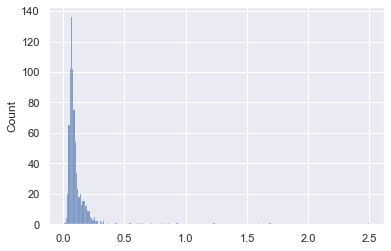

In [142]:
sns.histplot(test_pred.data.reshape(-1))

In [147]:
sample["C"]

AssertionError: Numpy dataset support only np.ndarray features

In [146]:
sample["C"] = sample["C"].clip(0, 1)

TypeError: '<=' not supported between instances of 'NumpyDataset' and 'int'

In [157]:
sample = pd.read_csv("../data/sample_submission.csv")

In [153]:
c_saved = test_pred.data.reshape(-1)

In [158]:
sample["TST"] = test_pred.data

In [159]:
sample

,NPLV,TST,C
0,512324,1656.837402,0.0
1,512327,1660.210938,0.0
2,512328,1660.346558,0.0
3,512331,1645.360840,0.0
4,512333,1664.917603,0.0
...,...,...,...
775,513369,1648.688965,0.0
776,513370,1658.745850,0.0
777,513371,1657.646729,0.0
778,513372,1667.255371,0.0


In [163]:
sample["C"] = c_saved.clip(0, 1)

In [164]:
sample.to_csv("AAAutoML.csv", index=False)

<AxesSubplot:xlabel='C', ylabel='Count'>

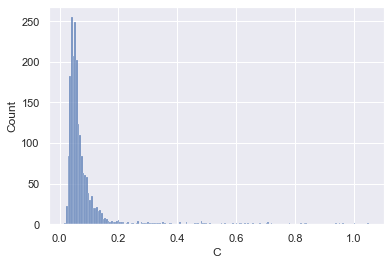

In [144]:
sns.histplot(y["C"])

# Уэаээааяаяаяаяыыы

In [167]:
train_mean = pd.read_csv("train_mean.csv").set_index("NPLV")
test_mean = pd.read_csv("test_mean.csv").set_index("NPLV")

In [172]:
train_mean = train_mean.loc[y.index]
test_mean = test_mean.loc[sample["NPLV"]]

In [188]:
from xgboost import XGBRegressor
from sklearn.svm import NuSVR

model_c = XGBRegressor(n_estimators=30)
model_tst = XGBRegressor(n_estimators=30)

res = pipeline(model_c, model_tst, train.values, test.values, train.values, test.values, y, sample, n_splits=100,
              pwc=pwrC, pwt=pwrT)

  0%|          | 0/100 [00:00<?, ?it/s]

Carbon score: 0.728404761904762 ± 0.08971879411884998
Temperature score: 0.6801904761904761 ± 0.09678322787176975
Overall score: 0.7042976190476192 ± 0.07338277071230663


array([[<AxesSubplot:title={'center':'NPLV'}>,
        <AxesSubplot:title={'center':'TST'}>],
       [<AxesSubplot:title={'center':'C'}>, <AxesSubplot:>]], dtype=object)

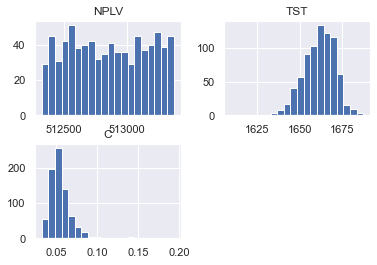

In [189]:
res.hist(bins=20)

In [190]:
res.to_csv("xgboost_new2.csv", index=False)

In [191]:
sorted(zip(model_tst.feature_importances_, train.columns), reverse=True)[:40]

[(0.113169126, 'O2_опер_0'),
 (0.066921264, 'total_operations_опер_0'),
 (0.05491306, 'plavka_NAPR_ZAD'),
 (0.050681137, 'bow_Ст3'),
 (0.03952316, 'gas_std_volume_H2'),
 (0.02207011, 'durationproduv_'),
 (0.01753978, 'w2v_7'),
 (0.016271645, 'w2v_0'),
 (0.01495365, 'unique_count'),
 (0.014425828, 'RAS_mean'),
 (0.013933238, 'gas_mean_volume_CO2'),
 (0.013611314, 'gas_std_volume_CO2'),
 (0.012184505, 'truncated_NMZ'),
 (0.011110511, '1'),
 (0.010784369, '7'),
 (0.010361643, 'w2v_8'),
 (0.010298041, 'st_diff_is_zero'),
 (0.010218833, 'w2v_1'),
 (0.0101285055, 'MN'),
 (0.010123135, 'gas_sum_volume_H2'),
 (0.009731754, 'gas_std_CO2'),
 (0.009391666, 'POL_mean'),
 (0.009325557, '5'),
 (0.009195856, 's_portion'),
 (0.0089969095, 'gas_std_H2'),
 (0.008892464, 'total_duration_межпл.прост._1'),
 (0.008748604, 'gas_std_volume_AR'),
 (0.0084321285, 'gas_mean_volume_N2'),
 (0.007987205, 'w2v_2'),
 (0.0078849625, 'total_duration_опер_0'),
 (0.007490053, 'gas_std_O2_pressure'),
 (0.0072476836, 'T'),